# Problem Set #5: Development

In [150]:
import cantera as ct
import numpy as np
import matplotlib.pyplot as plt
import os

## 1) Get everything set up

In [151]:
# path to kinetic mechanism
# fname_mech = os.path.abspath('..') + '\\mechanisms\\stanford-mech_v12.cti'
fname_mech = 'gri30.cti'
fname_mech

'gri30.cti'

In [152]:
# create the solution instance
sln = ct.Solution(fname_mech)
sln()


  gri30:

       temperature             300  K
          pressure          101325  Pa
           density       0.0818891  kg/m^3
  mean mol. weight         2.01588  amu

                          1 kg            1 kmol
                       -----------      ------------
          enthalpy           26470        5.336e+04     J
   internal energy     -1.2109e+06       -2.441e+06     J
           entropy           64914        1.309e+05     J/K
    Gibbs function     -1.9448e+07        -3.92e+07     J
 heat capacity c_p           14312        2.885e+04     J/K
 heat capacity c_v           10187        2.054e+04     J/K

                           X                 Y          Chem. Pot. / RT
                     -------------     ------------     ------------
                H2              1                1         -15.7173
     [  +52 minor]              0                0



In [153]:
species = sln.species_names
species

['H2',
 'H',
 'O',
 'O2',
 'OH',
 'H2O',
 'HO2',
 'H2O2',
 'C',
 'CH',
 'CH2',
 'CH2(S)',
 'CH3',
 'CH4',
 'CO',
 'CO2',
 'HCO',
 'CH2O',
 'CH2OH',
 'CH3O',
 'CH3OH',
 'C2H',
 'C2H2',
 'C2H3',
 'C2H4',
 'C2H5',
 'C2H6',
 'HCCO',
 'CH2CO',
 'HCCOH',
 'N',
 'NH',
 'NH2',
 'NH3',
 'NNH',
 'NO',
 'NO2',
 'N2O',
 'HNO',
 'CN',
 'HCN',
 'H2CN',
 'HCNN',
 'HCNO',
 'HOCN',
 'HNCO',
 'NCO',
 'N2',
 'AR',
 'C3H7',
 'C3H8',
 'CH2CHO',
 'CH3CHO']

In [154]:
rxns = sln.reaction_equations()
rxns

['2 O + M <=> O2 + M',
 'H + O + M <=> OH + M',
 'H2 + O <=> H + OH',
 'HO2 + O <=> O2 + OH',
 'H2O2 + O <=> HO2 + OH',
 'CH + O <=> CO + H',
 'CH2 + O <=> H + HCO',
 'CH2(S) + O <=> CO + H2',
 'CH2(S) + O <=> H + HCO',
 'CH3 + O <=> CH2O + H',
 'CH4 + O <=> CH3 + OH',
 'CO + O (+M) <=> CO2 (+M)',
 'HCO + O <=> CO + OH',
 'HCO + O <=> CO2 + H',
 'CH2O + O <=> HCO + OH',
 'CH2OH + O <=> CH2O + OH',
 'CH3O + O <=> CH2O + OH',
 'CH3OH + O <=> CH2OH + OH',
 'CH3OH + O <=> CH3O + OH',
 'C2H + O <=> CH + CO',
 'C2H2 + O <=> H + HCCO',
 'C2H2 + O <=> C2H + OH',
 'C2H2 + O <=> CH2 + CO',
 'C2H3 + O <=> CH2CO + H',
 'C2H4 + O <=> CH3 + HCO',
 'C2H5 + O <=> CH2O + CH3',
 'C2H6 + O <=> C2H5 + OH',
 'HCCO + O <=> 2 CO + H',
 'CH2CO + O <=> HCCO + OH',
 'CH2CO + O <=> CH2 + CO2',
 'CO + O2 <=> CO2 + O',
 'CH2O + O2 <=> HCO + HO2',
 'H + O2 + M <=> HO2 + M',
 'H + 2 O2 <=> HO2 + O2',
 'H + H2O + O2 <=> H2O + HO2',
 'H + N2 + O2 <=> HO2 + N2',
 'AR + H + O2 <=> AR + HO2',
 'H + O2 <=> O + OH',
 '2 H 

In [155]:
# set up the conditions
oxidizer = {'AR': .99, 'O2':.01}
fuel = {'CH4':1.}
P0 = 101325.

In [156]:
def reset_sln(sln, T, P=P0, phi=1.):
    sln.TP = T, P
    sln.set_equivalence_ratio(phi=phi, oxidizer=oxidizer, fuel=fuel)

reset_sln(sln, 1200)
sln()


  gri30:

       temperature            1200  K
          pressure          101325  Pa
           density        0.403681  kg/m^3
  mean mol. weight           39.75  amu

                          1 kg            1 kmol
                       -----------      ------------
          enthalpy      4.6945e+05        1.866e+07     J
   internal energy      2.1845e+05        8.683e+06     J
           entropy          4665.5        1.855e+05     J/K
    Gibbs function     -5.1291e+06       -2.039e+08     J
 heat capacity c_p          534.23        2.124e+04     J/K
 heat capacity c_v          325.06        1.292e+04     J/K

                           X                 Y          Chem. Pot. / RT
                     -------------     ------------     ------------
                O2     0.00995025       0.00800997         -31.6972
               CH4     0.00497512       0.00200792          -38.911
                AR       0.985075         0.989982         -20.2274
     [  +50 minor]        

In [157]:
# set up the reactor and network
r1 = ct.ConstPressureReactor(contents=sln, energy='on')
r1

In [158]:
rnet = ct.ReactorNet(reactors=(r1,))
rnet

In [159]:
def reset_reactor(sln,  T, rnet=rnet, P=P0, phi=1.):
    reset_sln(sln, T, P=P, phi=phi)
    rnet.set_initial_time(0)

In [160]:
reset_reactor(sln, 1200)

ts, Ts, spcs = [], [], {}
for sp in sln.species_names:
    spcs[sp] = []

In [161]:
def get_state(rnet, ts=ts, Ts=Ts, spcs=spcs):
    ts += [rnet.time]
    Ts += [sln.T]
    sp_dict = sln.mole_fraction_dict()
    for sp in sln.species_names:
        spcs[sp] += [sp_dict.get(sp, 0)]

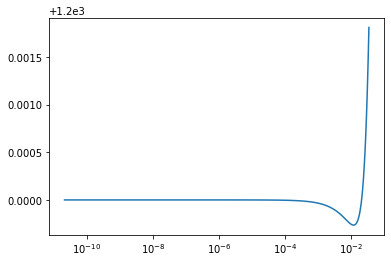

In [162]:
for i in range(100):
    rnet.step()
    get_state(rnet)

plt.semilogx(ts, Ts)

(1e-05, 0.1)

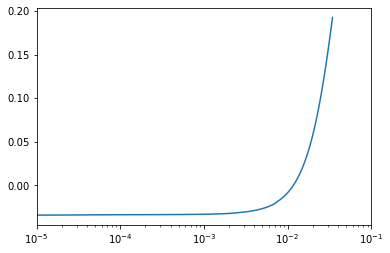

In [163]:
plt.semilogx(ts[:-1], np.diff(Ts) / np.diff(ts))
plt.xlim((1e-5, 1e-1))

(0.0001, 0.1)

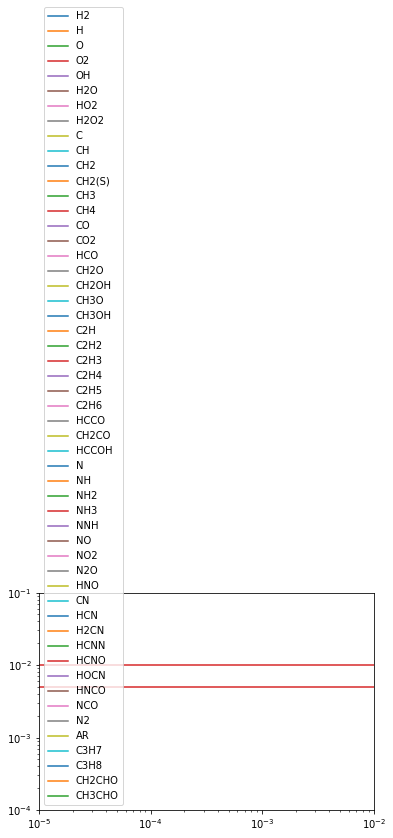

In [164]:
# for sp in ['O2', 'H2', 'OH', 'H']:
for sp in sln.species_names:
    plt.loglog(ts, spcs[sp], label=sp)
plt.legend()
plt.xlim((1e-5, 1e-2))
plt.ylim((1e-4, 1e-1))

In [165]:
t_ign = {}
for sp in ['O', 'OH', 'H']:
    t_ign[sp] = ts[np.argmax(spcs[sp])]

dT_dt = np.diff(Ts) / np.diff(ts)
t_ign['T'] = ts[:-1][np.argmax(dT_dt)]

t_ign

{'O': 0.0350449799183615,
 'OH': 0.0350449799183615,
 'H': 0.0350449799183615,
 'T': 0.034320755628395545}

In [166]:
reset_reactor(sln, 1200)
sln.equilibrate('HP')
T_eq = sln.T
T_eq

1388.2518994482002

In [167]:
def calc_T_ign_stop(sln, fractional_rise=0.95) -> float:
    """
    calculates the temperature at which to stop an ignition delay simulation
    :param sln: ct.Solution at initial simulation conditions
    :return T_stop: float, stopping temperature
    """

    TPX_0 = sln.TPX

    # get the equilibrium temperature of the solution to use as a stop condition
    sln.equilibrate('HP')
    Teq = sln.T

    # calculate the temperature at which to stop the simulation
    T_stop = TPX_0[0] + fractional_rise * (Teq - TPX_0[0])

    sln.TPX = TPX_0

    return T_stop

def add_state_to_dict(sln, rnet, result_dict):
    result_dict['time'] += [rnet.time]
    result_dict['T'] += [sln.T]
    for sp, x in zip(sln.species_names, sln.X):
        result_dict[sp] += [x]

def ignition_delay_dY_dt(res_dict, Y_key):
    ts = res_dict['time']
    ts_mean = ts[:-1] + np.diff(ts) / 2

    Ys = res_dict[Y_key]
    dY_dt = np.diff(Ys) / np.diff(ts)

    return ts_mean[np.argmax(dY_dt)]

def ignition_delay_maxY(res_dict, Y_key):
    ts = res_dict['time']
    return ts[np.argmax(res_dict[Y_key])]

def calculate_ignition_delays(res_dict):
    ign_delays = {'T':ignition_delay_dY_dt(res_dict, 'T'),
                  'H2O':ignition_delay_dY_dt(res_dict, 'H2O'),
                  'OH':ignition_delay_dY_dt(res_dict, 'OH')}
    return ign_delays

def run_ignition_simulation(sln, T_stop=None, verbose=False):
    """

    :param sln:
    :return:
    """
    if T_stop is None:  # get the stop condition
        T_stop = calc_T_ign_stop(sln)

    # set up the reactor and network
    r1 = ct.ConstPressureReactor(sln)
    rnet = ct.ReactorNet((r1, ))

    # set up dictionary of lists to store time-series results
    result_dict = {'time':[], 'T':[]}
    for sp in sln.species_names:
        result_dict[sp] = []

    while sln.T < T_stop:
        rnet.step()
        add_state_to_dict(sln, rnet, result_dict)

    if verbose:
        print(f'Number of simulation steps = {len(result_dict["time"])}')
        print(f'Reactor end time = {result_dict["time"][-1]*1e3:4.2f} ms')

    return result_dict

def set_xlim_min(xmin):
    xlims = plt.gca().get_xlim()
    plt.xlim((xmin, xlims[1]))

In [168]:
# %%timeit

reset_sln(sln, 1200)
result_dict = run_ignition_simulation(sln)
ign_delay = calculate_ignition_delays(result_dict)
print(ign_delay)

{'T': 1.6721319290039642, 'H2O': 1.6722302348389637, 'OH': 1.6722715335063314}


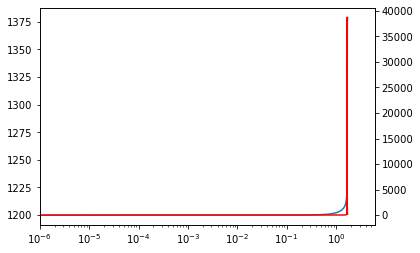

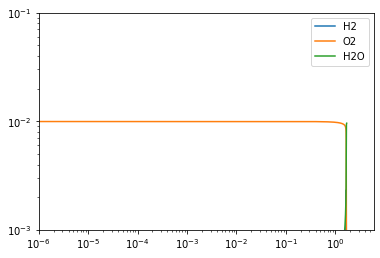

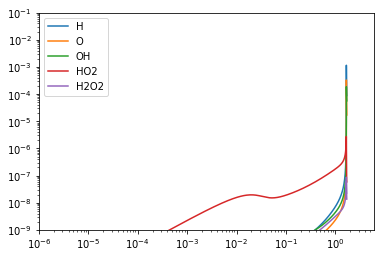

In [169]:
plt.figure()
plt.semilogx(result_dict['time'], result_dict['T'])
set_xlim_min(1e-6)
# plot dT/dt
ts = result_dict['time']
Ts = result_dict['T']
dT_dt = np.diff(Ts) / np.diff(ts)
ts = ts[:-1] + np.diff(ts)/2
ax2 = plt.twinx()
ax2.plot(ts, dT_dt, 'r')

plt.figure()
for sp in sln.species_names:
    if sp in ['H2', 'O2', 'H2O']:
        plt.loglog(result_dict['time'], result_dict[sp], label=sp)
plt.legend()
plt.ylim((1e-3, 1e-1))
set_xlim_min(1e-6)

plt.figure()
for sp in sln.species_names:
    if sp in ['OH', 'O', 'H', 'HO2', 'H2O2', ]:
        plt.loglog(result_dict['time'], result_dict[sp], label=sp)

plt.ylim((1e-9, 1e-1))
set_xlim_min(1e-6)
plt.legend()

In [170]:
T0s = np.arange(1200, 2001, 100)
ign_delays = {}

for T0 in T0s:
    reset_sln(sln, T0)
    result_dict = run_ignition_simulation(sln)
    ign_delays[T0] = calculate_ignition_delays(result_dict)

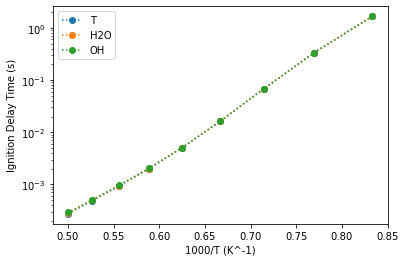

In [171]:
ign_delay_by_type = {}
for method in ign_delays[T0s[0]].keys():
    ign_delay_by_type[method] = []
    for T0 in ign_delays.keys():
        ign_delay_by_type[method] += [ign_delays[T0][method]]

    plt.semilogy(1000/T0s, np.array(ign_delay_by_type[method]), 'o:', label=method)

plt.legend()
plt.xlabel('1000/T (K^-1)')
plt.ylabel('Ignition Delay Time (s)');

In [172]:
R_cal = 1.987  # cal/mol-K

for method in ign_delay_by_type.keys():
    fit = np.polyfit(1/T0s, np.log(ign_delay_by_type[method]), 1)
    print(f'Ea_{method:3s} = {fit[0] * R_cal / 1e3: 4.2f} kcal/mol')

Ea_T   =  52.99 kcal/mol
Ea_H2O =  52.84 kcal/mol
Ea_OH  =  52.64 kcal/mol


## Sensitivity

In [181]:
sens_ign_delays = {}
T0 = 1200

# get the base IDT solution
reset_sln(sln, T0)
result_dict = run_ignition_simulation(sln)
sens_ign_delays['base'] = calculate_ignition_delays(result_dict)['OH']
d_rxn = 0.1

for ir in range(sln.n_reactions):
    reset_sln(sln, T0)

    if ir > 0:    # reset last multiplier
        sln.set_multiplier(1., ir-1)
    # set this multiplier
    sln.set_multiplier(1.+d_rxn, ir)

    result_dict = run_ignition_simulation(sln)
    sens_ign_delays[ir] = calculate_ignition_delays(result_dict)['OH']

In [182]:
idts = np.array(list(sens_ign_delays.values()))
idt0, rxn_ign = idts[0], idts[1:]

rxn_idt_sens = (idt0 - rxn_ign) / idt0 / d_rxn
rxn_strs = sln.reaction_equations()

rxn_ign

array([1.67227181, 1.67227322, 1.67137134, 1.67255772, 1.67227204,
       1.67227215, 1.6722733 , 1.6722717 , 1.6722735 , 1.67245488,
       1.67989318, 1.67227783, 1.67227281, 1.67227467, 1.67124155,
       1.67227311, 1.67227191, 1.67224713, 1.67227167, 1.67227174,
       1.67217247, 1.67227156, 1.67221122, 1.67227533, 1.67110966,
       1.67228584, 1.6678809 , 1.67227614, 1.67226321, 1.67218642,
       1.67224291, 1.63402592, 1.67219624, 1.67220059, 1.67219316,
       1.67227172, 1.66662202, 1.58841903, 1.67227319, 1.67227134,
       1.67227362, 1.67227345, 1.67227282, 1.67238335, 1.67410603,
       1.6745155 , 1.67223334, 1.67227463, 1.67227413, 1.67227268,
       1.672273  , 1.67575048, 1.7303571 , 1.67222155, 1.67229408,
       1.67223707, 1.67381668, 1.67906267, 1.67227138, 1.67227297,
       1.67211956, 1.67227087, 1.6722733 , 1.67227134, 1.67227478,
       1.67227331, 1.67227465, 1.67220552, 1.67227312, 1.67227231,
       1.67324826, 1.67227279, 1.67228788, 1.67790712, 1.67016

In [185]:
nmax = 12
# get the nmax most sensitive reactions
isort = np.argsort(np.abs(rxn_idt_sens))[::-1][:12]

sorted_sens, sorted_strs = rxn_idt_sens[isort], np.array(rxn_strs)[isort]

isort = np.argsort(sorted_sens)
print(sorted_sens)
print(isort)
sorted_sens, sorted_strs = sorted_sens[isort], sorted_strs[isort]
print()
for sens, string in zip(sorted_sens, sorted_strs):
    print(f'{string:30s}: {sens:4.3f}')
# print(sorted_sens)
# print(sorted_strs)

[ 0.50143174 -0.50088143  0.42996802 -0.3473421   0.32401146  0.22870762
  0.16099385 -0.15861624 -0.1467714   0.11205913  0.07355223  0.05991012]
[ 1  3  7  8 11 10  9  6  5  4  2  0]

2 CH3 (+M) <=> C2H6 (+M)      : -0.501
CH4 + H <=> CH3 + H2          : -0.347
HCO + M <=> CO + H + M        : -0.159
CH4 + OH <=> CH3 + H2O        : -0.147
2 CH3 <=> C2H5 + H            : 0.060
CH2O + CH3 <=> CH4 + HCO      : 0.074
CH3 + HO2 <=> CH3O + OH       : 0.112
HCO + O2 <=> CO + HO2         : 0.161
CH2O + O2 <=> HCO + HO2       : 0.229
CH3 + O2 <=> CH3O + O         : 0.324
CH3 + O2 <=> CH2O + OH        : 0.430
H + O2 <=> O + OH             : 0.501


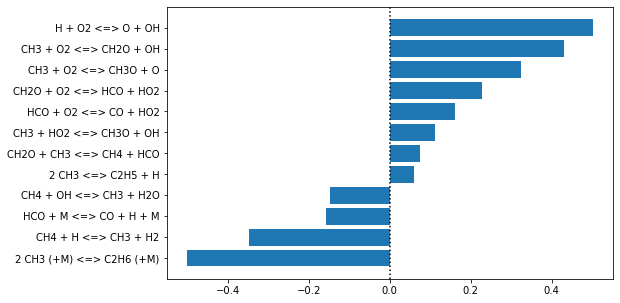

In [188]:
plt.figure(figsize=(8, 5))
plt.barh(range(nmax), sorted_sens)
plt.yticks(range(nmax), sorted_strs)
plt.axvline(0, c='k', ls=':')

In [187]:
reset_sln(sln, 1500)
rxn_dgrm = ct.ReactionPathDiagram(sln, 'OH')
rxn_dgrm.build()
rxn_dgrm.log

'\nReaction 1: 2 O + M <=> O2 + M ... OK.\n\nReaction 2: H + O + M <=> OH + M ... OK.\n\nReaction 3: H2 + O <=> H + OH ... OK.\n\nReaction 4: HO2 + O <=> O2 + OH ... ambiguous.\n     (O) + (O)(O-H) = (O)(O) + (O-H)   [<= default] \n     (O) + (H)(O2) = (O)(H) + (O2)\n\nReaction 5: H2O2 + O <=> HO2 + OH ... ambiguous.\n     (O) + (H)(O2-H) = (O)(H) + (O2-H)   [<= default] \n     (O) + (O-H)(O-H) = (O)(O-H) + (O-H)\n\nReaction 6: CH + O <=> CO + H ... OK.\n\nReaction 7: CH2 + O <=> H + HCO ... OK.\n\nReaction 8: CH2(S) + O <=> CO + H2 ... OK.\n\nReaction 9: CH2(S) + O <=> H + HCO ... OK.\n\nReaction 10: CH3 + O <=> CH2O + H ... OK.\n\nReaction 11: CH4 + O <=> CH3 + OH ... OK.\n\nReaction 12: CO + O (+M) <=> CO2 (+M) ... OK.\n\nReaction 13: HCO + O <=> CO + OH ... ambiguous.\n     (O) + (H)(O-C) = (O)(H) + (O-C)   [<= default] \n     (O) + (C)(O-H) = (O)(C) + (O-H)\n\nReaction 14: HCO + O <=> CO2 + H ... OK.\n\nReaction 15: CH2O + O <=> HCO + OH ... ambiguous.\n     (O) + (H)(O-H-C) = (O)